In [1]:
#!pip install keras
#!pip install visualkeras


In [2]:
#source code
#https://github.com/KhuyenLE-maths/LeNet_model_with_MNIST_recognition/blob/main/LeNet_with_MNIST_recognition.ipynb

In [3]:
from tensorflow import keras
import keras.layers as layers
from keras.utils import to_categorical
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input,LeakyReLU,Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy, binary_crossentropy
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import chain
import ast

In [4]:
#Load model / training data
LeNet_model = load_model('LeNet_model.keras')
training_data_m2 = pd.read_csv('training_data_m2.csv')



In [5]:
#load images from MNIST, split into images and labels
(train_img, train_label), (test_img, test_label) = mnist.load_data()

#Create binary labels, either 9 or !9
train_labels_binary = (train_label == 9).astype(int)
test_labels_binary = (test_label == 9).astype(int)

#Concat to be able to control training size
x = np.concatenate((train_img, test_img))
y = np.concatenate((train_labels_binary, test_labels_binary))

#set training size percentage
train_size = 0.8

#split into train and test data / label
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=train_size)
print('X_train shape', X_train.shape, 'X_test shape', X_test.shape)

X_train shape (56000, 28, 28) X_test shape (14000, 28, 28)


In [6]:
def LeNet():
  model = Sequential()
  
  # Convolutional layer  
  model.add(Conv2D(filters = 6, kernel_size = (5,5), padding = 'same', 
                   activation = 'relu', input_shape = (28,28,1)))
  
  # Max-pooing layer with pooling window size is 2x2
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  # Convolutional layer 
  model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu'))
  
  # Max-pooling layer 
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  # Flatten layer 
  model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(40, activation = 'relu'))
  
  # The output layer  
  model.add(Dense(2, activation = 'softmax'))
  
  # compile the model with a loss function, a metric and an optimizer function
  # In this case, the loss function is categorical crossentropy (binary_crossentropy), 
  # we use Stochastic Gradient Descent (SGD) method with learning rate lr = 0.01 to optimize the loss function
  # metric: accuracy 
  
  opt = SGD(learning_rate=0.02)
  model.compile(loss = binary_crossentropy,
                optimizer = opt, 
                metrics = ['accuracy']) 
  # Extract vectors from specific layers
  output_specific_layer = Model(inputs=model.input, 
                                  outputs=model.layers[5].output)
  output_img_data = Model(inputs=model.input, 
                                  outputs=model.layers[2].output)
  
  return model,output_specific_layer,output_img_data

In [7]:
def preprocess_data(X_train, y_train, X_test, y_test):
  # reshape images to the required size of Keras
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
  
  # convert image values from integers to floats
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  
  # normalization
  X_train = X_train/255.0
  X_test_norm = X_test/255.0
  
  # One-hot encoding label 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  
  return X_train, y_train, X_test, y_test

In [8]:
LeNet_model , output_specific_layer, output_img_data =  LeNet()
LeNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 40)                1

In [9]:
def summary_history(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

def train_model(model, X_train, y_train, X_test, y_test, epochs = 2, batch_size = 128):
  # Rescaling all training and testing data
  X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)
  # Fitting the model on the training set
  history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, 
                      steps_per_epoch = X_train.shape[0]//batch_size, 
                      validation_data = (X_test, y_test), 
                      validation_steps = X_test.shape[0]//batch_size, verbose = 1)
  # evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  summary_history(history)

Epoch 1/2
437/437 [==============================] - 12s 26ms/step - loss: 0.2743 - accuracy: 0.8992 - val_loss: 12.9181 - val_accuracy: 0.9227
Epoch 2/2
438/438 [==============================] - 1s 3ms/step - loss: 10.8515 - accuracy: 0.9456
94.557


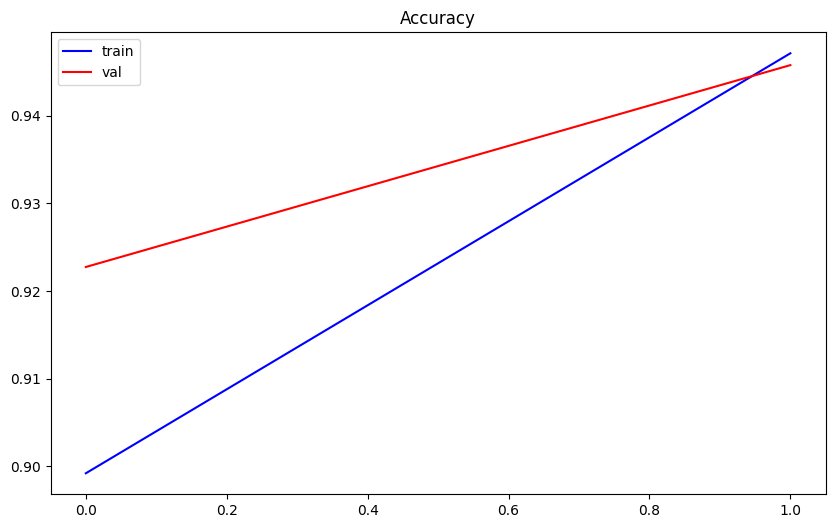

In [10]:
train_model(LeNet_model, X_train, Y_train, X_test, Y_test)

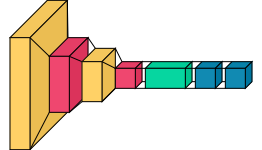

In [11]:
visualkeras.layered_view(LeNet_model)

In [12]:
# predict labels for the test set
y_test_pred = []
vec_p_list = []
out_list = []
img_data = []
for i in range(len(X_test)):
  img = X_test[i]
  img = img.reshape(1,28,28,1)
  img = img.astype('float32')
  img = img/255.0
  # one-hot vector output
  vec_p = LeNet_model.predict(img)
  out_list.append(output_specific_layer.predict(img))
  img_data.append(output_img_data.predict(img))
  print()
  # determine the label corresponding to vector vec_p
  y_p = np.argmax(vec_p)
  y_test_pred.append(y_p)
  vec_p_list.append(vec_p)
  
  
# convert y_test_pred from list to array
y_test_pred = np.asarray(y_test_pred)

1/1 [==============================] - 0s 50ms/step

1/1 [==============================] - 0s 38ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 80ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms

Text(70.72222222222221, 0.5, 'True classes')

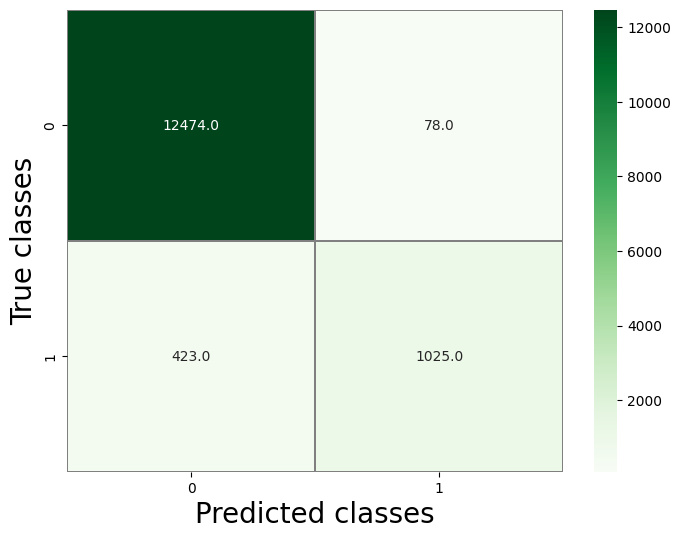

In [13]:
con_mat = confusion_matrix(Y_test, y_test_pred)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

0
0
0
0
1
0
0
0


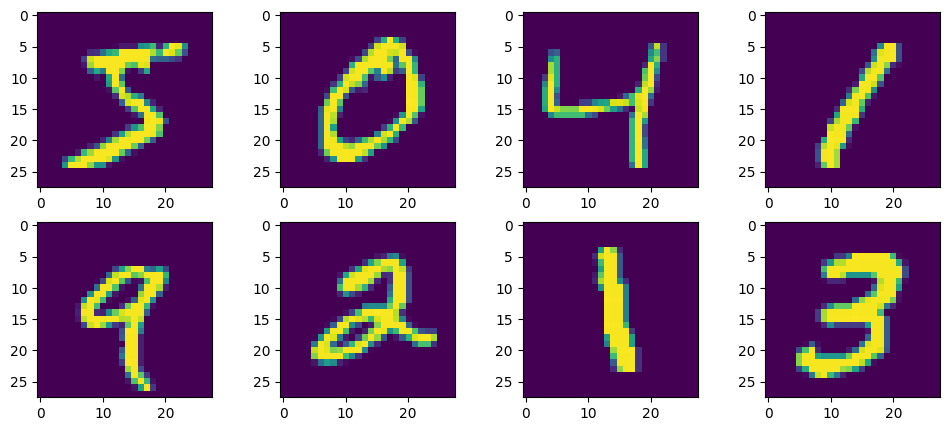

In [14]:
plt.figure(figsize = (12,5))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240+1+i)
  plt.imshow(train_img[i])
  print(train_labels_binary[i])

In [15]:
#pandas display options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.6f}'.format)




In [18]:
len(img_data)

14000

In [26]:
training_data_m2 = pd.DataFrame()

training_data_m2['img last conv layer'] = img_data
training_data_m2['argument before fc layer'] = out_list
training_data_m2['m1 pred'] = y_test_pred
training_data_m2['label'] = Y_test


In [27]:
training_data_m2.head(50)

img last conv layer  \
0   [[[[0.00660951 0.         0.15582964 0.12151143 0.41535887 0.\n 0.         0.12323774 0.         0.3325515  0.5427155  0.03038859\n 0.14046022 0.16351254 0.         0.34071004], [0.         0.         0.12358476 0.12804967 0.43420318 0.\n 0.         0.04629657 0.         0.35435528 0.5722733  0.02733152\n 0.19574834 0.22424968 0.         0.45073903], [0.         0.06910066 0.         0.1299381  0.42249134 0.\n 0.         0.         0.         0.4224953  0.61480767 0.02206352\n 0.21841376 0.13304886 0.0888705  0.9349234 ], [0.         0.40429235 0.         0.38345602 0.5741405  0.\n 0.         0.06923253 0.         0.6043378  0.9202652  0.\n 0.21572925 0.         0.37435982 1.3398061 ], [0.         0.65225714 0.         0.711848   0.63893014 0.\n 0.         0.11787619 0.         0.8148279  1.5739231  0.\n 0.4480738  0.         0.29562336 1.7937226 ], [0.         0.44843155 0.         0.8769158  0.8026836  0.\n 0.         0.14981133 0.         1.2901001  2.2605872  0.\n 0.3458943  0.         0.15324092 1.794826  ], [0.         0.45234612 0.         0.94591725 0.93754065 0.\n 0.         0.         0.         1.8976566  3.0029163  0.\n 0.36688772 0.         0.20770203 1.5723747 ], [0.         0.11276881 0.20647703 1.1547023  1.0658829  0.\n 0.         0.         0.         2.309585   3.7306087  0.\n 0.48474354 0.         0.21688834 0.9562259 ], [0.         0.         1.0453409  1.0074631  0.94581383 0.\n 0.         0.04642706 0.         1.9959143  3.500823   0.\n 0.8093022  0.         0.         0.5160256 ], [0.         0.         1.1715112  0.3697066  0.96113205 0.\n 0.         0.01666656 0.         1.4384948  2.8148868  0.\n 0.75121766 0.         0.         0.        ]], [[0.0291225  0.         0.14942706 0.12392365 0.44071588 0.\n 0.         0.12704413 0.         0.32872653 0.54115754 0.03689228\n 0.1285452  0.19207475 0.         0.33419073], [0.         0.         0.02348237 0.11804817 0.39548162 0.\n 0.         0.05596503 0.         0.34855303 0.51541984 0.03234088\n 0.25670338 0.22363308 0.         0.68874854], [0.         0.03633721 0.         0.28949243 0.5912223  0.\n 0.         0.03336363 0.         0.40481973 0.64506096 0.\n 0.25983167 0.04302279 0.23137836 1.1970301 ], [0.         0.38263988 0.         0.41335306 0.96842754 0.\n 0.         0.04802278 0.         0.61357176 1.477334   0.\n 0.05142412 0.         0.20239756 1.7725482 ], [0.         0.22849922 0.04819395 0.7461089  1.1420698  0.\n 0.         0.12469034 0.         0.86590743 2.350833   0.\n 0.14750087 0.         0.         1.8991586 ], [0.         0.09090395 0.44044504 0.70668113 1.5256181  0.\n 0.         0.18700846 0.         1.3473185  3.0846863  0.\n 0.         0.         0.         1.5566757 ], [0.         0.04100027 0.34523857 0.9142434  2.195947   0.\n 0.         0.03941964 0.         1.6424546  3.9200106  0.\n 0.0587028  0.27903157 0.         1.389486  ], [0.         0.17942134 0.34762293 1.7786609  2.1995306  0.\n 0.         0.21648028 0.         1.9831841  4.2900724  0.\n 0.         0.28255922 0.         1.2385328 ], [0.         0.19442518 0.5471699  2.0702262  1.6844324  0.\n 0.         0.5122101  0.         2.1773927  4.113032   0.13326925\n 0.         0.30186546 0.         0.6011831 ], [0.         0.         0.41192186 1.3972571  1.5610392  0.\n 0.         0.42869112 0.         2.0524383  3.3015473  0.\n 0.         0.32903606 0.         0.        ]], [[0.03399037 0.         0.1399884  0.10143614 0.44697136 0.\n 0.         0.12024756 0.         0.30582523 0.52816445 0.03876413\n 0.13035418 0.19825208 0.         0.35439608], [0.         0.         0.         0.09609839 0.39461124 0.\n 0.         0.07853662 0.         0.27012148 0.43595305 0.\n 0.33396298 0.15598331 0.07952863 0.90454334], [0.0000000e+00 6.5317303e-02 0.0000000e+00 9.3292281e-02 9.4038153e-01\n 0.0000000e+00 0.0000000e+00 1.2150593e-03 0.0000000e+00 4.2375773e-01\n 1.0251627e+00 0.0000000e+00 2.7841502e-01 0.0000000e+00 1.9874048e-01\n 1.6637110e+00], [0.

In [28]:
#Save model / training data to file

#LeNet_model.save('LeNet_model.keras')
training_data_m2.to_csv('training_data_m2.csv', index=False)

In [ ]:
def m2():
  model = Sequential()
     # Flatten layer 
  model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(40, activation = 'relu'))
  
  # The output layer  
  model.add(Dense(2, activation = 'softmax'))

  opt = SGD(learning_rate=0.02)
  model.compile(loss = binary_crossentropy,
                optimizer = opt, 
                metrics = ['accuracy']) 
  
  return model
    

In [ ]:
for x in training_data_m2['img last conv layer']:
    print(x)
#training_data_m2['argument before fc layer'] = training_data_m2['argument before fc layer'].apply(ast.literal_eval)

[[[[0.         0.27508917 0.21520948 ... 0.4028714  0.
    0.28915763]
   [0.         0.33110848 0.313616   ... 0.3532544  0.
    0.17553872]
   [0.         0.2100785  0.49113134 ... 0.24444994 0.02200599
    0.1754742 ]
   ...
   [0.         1.4992305  0.93710494 ... 1.5027114  0.33706012
    1.2314571 ]
   [0.         1.5062724  0.92607474 ... 1.7093619  0.69797856
    1.1960025 ]
   [0.         1.3097215  0.8913357  ... 1.7400484  0.6303935
    0.9198924 ]]

  [[0.         0.29256612 0.32568544 ... 0.3379125  0.
    0.1327957 ]
   [0.         0.30984288 0.56444186 ... 0.20540321 0.
    0.39540875]
   [0.         0.61755145 0.4477553  ... 0.26669627 0.
    0.72381455]
   ...
   [0.         1.8104291  1.5189332  ... 1.5162177  1.4893665
    1.5195606 ]
   [0.         2.0795486  1.2781583  ... 1.9813634  1.197971
    1.3855395 ]
   [0.         1.9449731  1.1371444  ... 2.286912   0.8138192
    1.1448233 ]]

  [[0.         0.39703345 0.47349945 ... 0.24831319 0.
    0.5228306 ]
   [0.02

In [ ]:
training_data_m2['m1 pred','label'] = training_data_m2['m1 pred','label'].astype(np.int32)
#training_data_m2['] = training_data_m2['m1 pred'].astype(np.int32)
X_train, X_test, Y_train, Y_test = train_test_split(training_data_m2.drop('label', axis=1),
                                                    training_data_m2['label'],
                                                    train_size=0.8
                                                    )

print('X_train shape', X_train.shape, 'X_test shape', X_test.shape)


KeyError: ('m1 pred', 'label')

In [ ]:
def train_m2(model, X_train, y_train, X_test, y_test, epochs = 10, batch_size = 128):
  # Rescaling all training and testing data
  #X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)
  # Fitting the model on the training set
  history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, 
                      steps_per_epoch = X_train.shape[0]//batch_size, 
                      validation_data = (X_test, y_test), 
                      validation_steps = X_test.shape[0]//batch_size, verbose = 1)
  # evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  summary_history(history)
#train_m2(LeNet_model, X_train, Y_train, X_test, Y_test)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 1130 to 873
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   img last conv layer       286 non-null    object
 1   argument before fc layer  286 non-null    object
 2   m1 pred                   286 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.9+ KB


In [ ]:
y_test_pred = []
for i in range(len(X_test)):
  img = X_test[i]
  # one-hot vector output
  vec_p = m2.predict()
  out_list.append(output_specific_layer.predict(img))
  img_data.append(output_img_data.predict(img))
  print()
  # determine the label corresponding to vector vec_p
  
  
# convert y_test_pred from list to array
y_test_pred = np.asarray(y_test_pred)

KeyError: 0

Class-specific Activations:

For each input image, you can extract the activations of the final layer (before the softmax) for each class. These activations represent how confident the model is about each class.
The output would be a vector where each element corresponds to the confidence score of the corresponding class.

Gradient-based Techniques:

Compute the gradients of the predicted class score with respect to the input image pixels. This gradient vector will show how each pixel affects the model's decision.
This gradient vector can be considered as a vector representing the reasoning behind the prediction.

Saliency Maps:

Compute the gradients of the model's output with respect to the input image pixels. This will result in a saliency map that highlights the importance of each pixel.
Convert the saliency map into a vector by reshaping or flattening it.

Attention Mechanisms:

If your CNN uses attention mechanisms, you can extract the attention weights as a vector for a specific class prediction.
Each element of the vector represents the attention weight assigned to a particular part of the input image.

LIME (Local Interpretable Model-agnostic Explanations):

Train a simpler, interpretable model on locally perturbed versions of the input image, and for each class, you can extract the model's output probabilities as a vector.
These vectors represent the reasoning of the interpretable model for each class.

Feature Visualization:

You can generate synthetic input images that maximize the activation of a particular class. The process of generating these images will result in a vector that represents the ideal input for that class.